# Normal likelihoods and normal-inverse-gamma priors

Today we explore how samples from a prior distribution can be interpreted as instances of the likelihood function. Specifically, we look at how samples from a normal-inverse-gamma (NIG) distribution can be interpreted as normal distributions.

**In short:** Each sample from the NIG distribution is a pair $(x, \sigma^2)$. These values specify the mean and variance of a normal distribution and so we can think of the sample (the pair of values) as an instance of the normal distribution (which will be our likelihood function). More below.

## Normal-inverse-gamma in SciPy

Even though SciPy does have classes defined for the normal distribution (`scipy.stats.norm`) and the inverse-gamma distribution (`scipy.stats.invgamma`), it does not have one defined for the normal-inverse-gamma distribution. To help you, the functions below implement the probability density function and a sampler for the normal-inverse-gamma distribution.

In [4]:
import numpy as np
import scipy.stats as sts
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [5]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu (μ), either lambda (λ) or nu (ν), alpha (α),
beta (β), are used as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third
parameter. This is to match the notation used in the conjugate priors table on
Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        sts.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        sts.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    # Sample sigma^2 from the inverse-gamma distribution
    sigma2 = sts.invgamma.rvs(a=alpha, scale=beta, size=size)
    # Sample x from the normal distribution
    x = sts.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)
    return np.vstack((x, sigma2)).transpose()

## Finding prior hyperparameters
- The data are normally distributed. The error margins given below represent 1
standard deviation from the mean of the parameter.
- Constraint: the mean of the data is approximately 2.3 ± 0.5.
- Constraint: the variance of the data is approximately 2.75 ± 1.
- Find μ₀, ν₀, α₀, β₀ hyperparameters for the normal-inverse-gamma prior that
match this information

In [54]:
def optim_f(arguments):
    mu, nu, alpha, beta = arguments
    mean_of_mean = mu - 2.3
    mean_of_var = beta / (alpha - 1) - 2.75
    std_of_mean = np.sqrt(beta / (nu * (alpha - 1))) - 0.5
    std_of_var = np.sqrt(beta**2 / ((alpha - 1)**2 * (alpha - 2))) - 1
    
    return mean_of_mean**2 + mean_of_var**2 + std_of_mean**2 + std_of_var**2

In [61]:
result = minimize(optim_f, np.array([5.0, 5.0, 5.0, 5.0]))

In [62]:
print("mu = {0}, nu = {1}, alpha = {2}, beta = {3}".format(
    result.x[0], result.x[1], result.x[2], result.x[3]
))

mu = 2.3000001907889995, nu = 11.001788777858517, alpha = 9.562554601977292, beta = 23.547049135415598


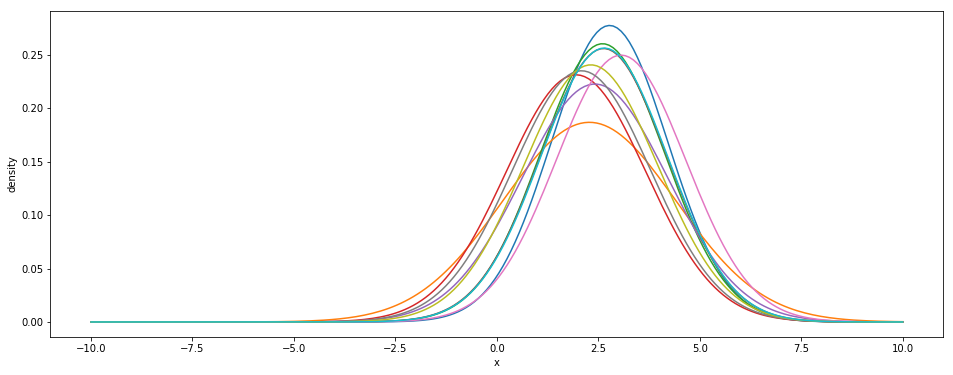

In [31]:
mu_0, nu_0, alpha_0, beta_0 = result.x
samples = norminvgamma_rvs(mu_0, nu_0, alpha_0, beta_0, size=10)

x_axis = np.linspace(-10, 10, 200)

plt.figure(figsize=(16, 6))
for i in range(samples.shape[0]):
    distribution = sts.norm(loc=samples[i][0], scale=np.sqrt(samples[i][1]))
    plt.plot(x_axis, distribution.pdf(x_axis))
plt.xlabel('x')
plt.ylabel('density')
plt.show()